In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from itertools import combinations
from pathlib import Path
from scipy.stats import ttest_ind_from_stats, wilcoxon

In [72]:
RESULTS_PATH = Path(r'E:\Pedro\Faculdade\FEI-Mestrado\LNCC\data\Results')

eval_dirs = ['Exp3-Transformers', 'Exp4-Resnet', 'Exp5-Vgg16', 'Exp6-Inceptionv3']
datasets = ['UNIFESP360', 'UNIFESP360-faces', 'UNIFESP360-faces-masked']
datasets_mosaico = ['UNIFESP360_Face', 'UNIFESP360_Regiões']

dirs_plot_names = {
    'Exp3-Transformers': 'ViT',
    'Exp4-Resnet': 'Resnet50',
    'Exp5-Vgg16': 'Vgg16',
    'Exp6-Inceptionv3': 'InceptionV3' 
}

# H0 = Duas médias são iguais
# p = probabilidade de algo tão ou mais raro acontecer
# p < p_threshold -> Raro demais, logo negamos H0 e dizemos que as medias são com certeza diferentes
p_threshold = 0.05
TEST_METRIC = 'f1'

In [73]:
results = {}
for ds in datasets:
    results[ds] = {}
    for dir in eval_dirs:
        count = 0
        for item_path in (RESULTS_PATH / dir / ds).rglob('*.csv'):
            df = pd.read_csv(item_path)
            del df['K']
            del df['test_loss']
            del df['test_runtime']
            del df['test_samples_per_second']
            del df['test_steps_per_second']
            df = df.rename(columns={col: col.replace('test_', '') for col in df.columns})
            results[ds][dirs_plot_names[dir]] = {
                'raw': df,
                'mean': df.mean(axis=0,numeric_only=True),
                'std': df.std(axis=0,numeric_only=True),
            }
            count+=1
            if count > 1:
                print(f"Multiple dataframes found for dataset {ds} - {dir}")

---

## Comparando modelos

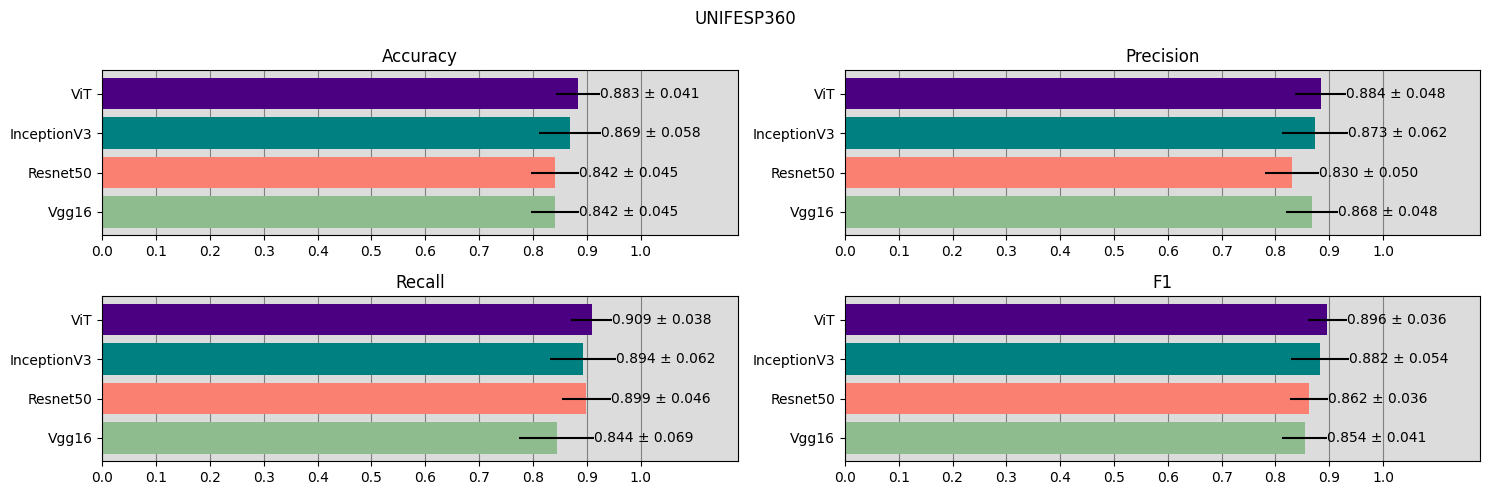

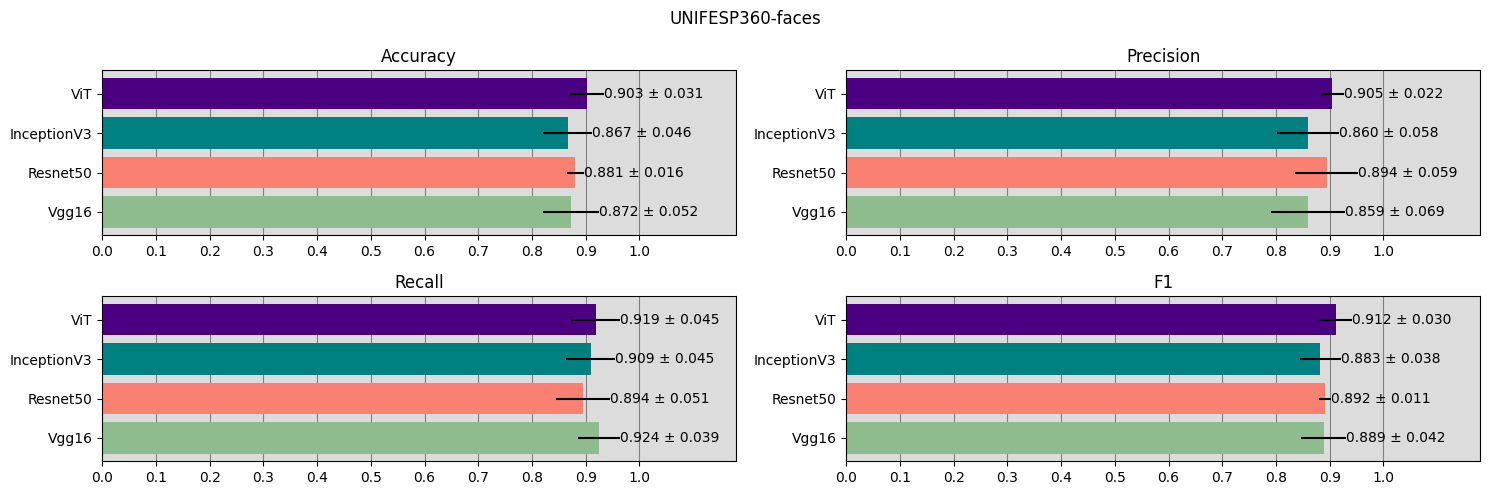

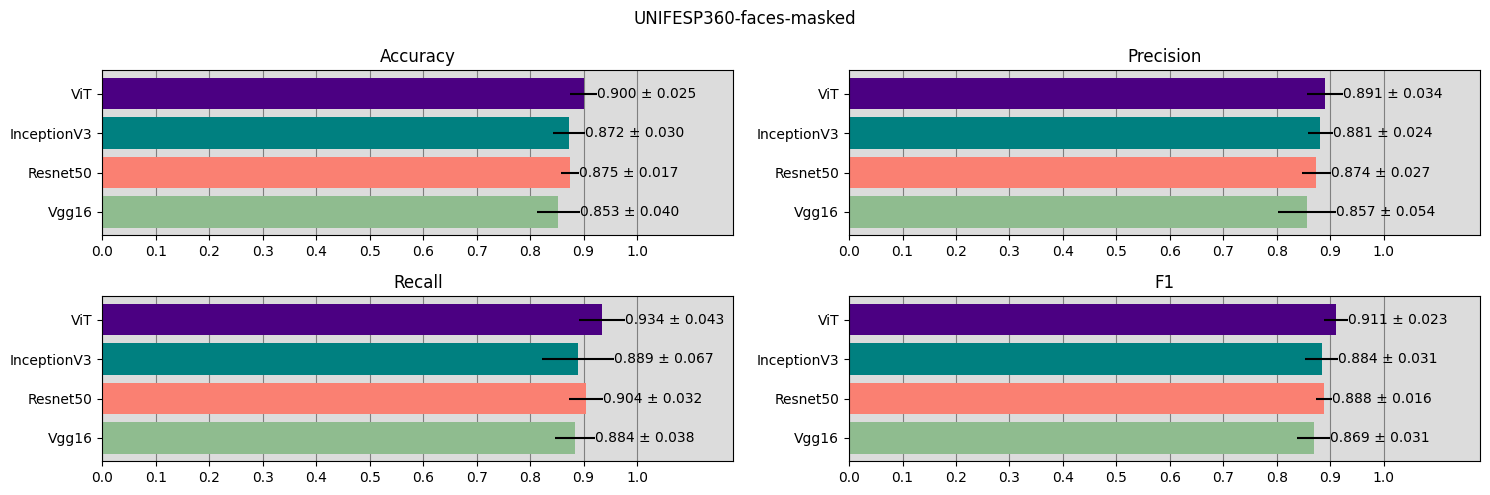

In [74]:
models = ['Vgg16', 'Resnet50', 'InceptionV3', 'ViT']
metrics = ['accuracy', 'precision', 'recall', 'f1']
dfs = {}
for dataset in datasets:
    data = results[dataset]

    dfs[dataset] = {metric: list() for metric in metrics}

    index = [dirs_plot_names[dir] for dir in eval_dirs]
    df_mean = pd.DataFrame([d['mean'] for d in data.values()], index=index)
    df_std = pd.DataFrame([d['std'] for d in data.values()], index=index)

    fig, axs = plt.subplots(2,2,figsize=(15,5))
    fig.suptitle(dataset)

    for count, metric in enumerate(metrics):
        j = count%2
        i = count//2

        sorted_df_mean = df_mean[metric][models]
        sorted_df_std = df_std[metric][models]

        for model in models:
            dfs[dataset][metric].append(f'{sorted_df_mean[model]:.3f}±{sorted_df_std[model]:.3f}')

        y_pos = np.arange(len(sorted_df_mean.index.to_numpy()))
        hbars = axs[i][j].barh(
            y_pos,
            sorted_df_mean.values,
            xerr=sorted_df_std.values,
            color=['darkseagreen', 'salmon', 'teal', 'indigo'],
        )

        axs[i][j].set_title(metric.capitalize())
        axs[i][j].set_axisbelow(True)
        axs[i][j].grid(axis='x', color='gray', zorder=0)
        axs[i][j].set_xlim(0,1.18)
        axs[i][j].bar_label(hbars, labels=[f'{mean:.3f} ± {std:.3f}' for mean,std in zip(sorted_df_mean.values, sorted_df_std.values)])
        axs[i][j].set_xticks([i/10 for i in range(11)])
        axs[i][j].set_yticks(y_pos, sorted_df_mean.index.to_numpy())
        axs[i][j].set_facecolor('gainsboro')
    fig.tight_layout()
    dfs[dataset] = pd.DataFrame(dfs[dataset], index=models)
plt.show()

In [75]:
def bold(col):
    r = re.compile(r'0.[0-9]{3}')
    max_val = ('', -1)
    for metric, value_string in col.items():
        value = float(r.match(value_string).group(0))
        if value > max_val[1]:
            max_val = (metric, value)
    return ['font-weight: bold;' if max_val[0] == idx else '' for idx in col.index]

for ds in dfs:
    print(f'>>> DATASET: {ds}')
    display(dfs[ds].style.apply(bold))
    print('-'*50)

>>> DATASET: UNIFESP360


,accuracy,precision,recall,f1
Vgg16,0.842±0.045,0.868±0.048,0.844±0.069,0.854±0.041
Resnet50,0.842±0.045,0.830±0.050,0.899±0.046,0.862±0.036
InceptionV3,0.869±0.058,0.873±0.062,0.894±0.062,0.882±0.054
ViT,0.883±0.041,0.884±0.048,0.909±0.038,0.896±0.036


--------------------------------------------------
>>> DATASET: UNIFESP360-faces


,accuracy,precision,recall,f1
Vgg16,0.872±0.052,0.859±0.069,0.924±0.039,0.889±0.042
Resnet50,0.881±0.016,0.894±0.059,0.894±0.051,0.892±0.011
InceptionV3,0.867±0.046,0.860±0.058,0.909±0.045,0.883±0.038
ViT,0.903±0.031,0.905±0.022,0.919±0.045,0.912±0.030


--------------------------------------------------
>>> DATASET: UNIFESP360-faces-masked


,accuracy,precision,recall,f1
Vgg16,0.853±0.040,0.857±0.054,0.884±0.038,0.869±0.031
Resnet50,0.875±0.017,0.874±0.027,0.904±0.032,0.888±0.016
InceptionV3,0.872±0.030,0.881±0.024,0.889±0.067,0.884±0.031
ViT,0.900±0.025,0.891±0.034,0.934±0.043,0.911±0.023


--------------------------------------------------


In [76]:
models = ['Vgg16', 'Resnet50', 'InceptionV3', 'ViT']
metric = TEST_METRIC
dfs = {}
p_values_table_index = list(combinations(models, 2))
p_values_table = {d: dict() for d in datasets}
p_values_table_wilcoxon = {d: dict() for d in datasets}
for dataset in datasets:
    data = results[dataset]

    dfs[dataset] = list()

    index = [dirs_plot_names[dir] for dir in eval_dirs]
    df_mean = pd.DataFrame([d['mean'] for d in data.values()], index=index)
    df_std = pd.DataFrame([d['std'] for d in data.values()], index=index)

    sorted_df_mean = df_mean[metric][models]
    sorted_df_std = df_std[metric][models]

    for model in models:
        dfs[dataset].append(f'{sorted_df_mean[model]:.3f}±{sorted_df_std[model]:.3f}')

    # T-Test
    for m1, m2 in p_values_table_index:
        t, p = ttest_ind_from_stats(
            sorted_df_mean[m1], sorted_df_std[m1], 5, # Model 1 (mean, std_dev, number of samples)
            sorted_df_mean[m2], sorted_df_std[m2], 5, # Model 2 (mean, std_dev, number of samples)
            alternative='two-sided')
        p_values_table[dataset][(m1,m2)] = f"{'same' if p > p_threshold else 'different'} (p={p:.3f})"

    # Wilcoxon signed-rank
    for m1, m2 in p_values_table_index:
        w_result = wilcoxon(
            data[m1]['raw']['f1'],
            data[m2]['raw']['f1'],
            alternative='two-sided')
        p_values_table_wilcoxon[dataset][(m1,m2)] = f"{'same' if p > p_threshold else 'different'} (p={p:.3f})"
        p_values_table_wilcoxon[dataset][(m1,m2)] = f"{'same' if w_result.pvalue > p_threshold else 'different'} (p={w_result.pvalue:.3f})"

dfs = pd.DataFrame(dfs, index=models)
display(dfs.style.apply(bold))
display(dfs.T.style.apply(bold))

c:\Users\12ped\anaconda3\envs\occ-gen\lib\site-packages\scipy\stats\_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\12ped\anaconda3\envs\occ-gen\lib\site-packages\scipy\stats\_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,UNIFESP360,UNIFESP360-faces,UNIFESP360-faces-masked
Vgg16,0.854±0.041,0.889±0.042,0.869±0.031
Resnet50,0.862±0.036,0.892±0.011,0.888±0.016
InceptionV3,0.882±0.054,0.883±0.038,0.884±0.031
ViT,0.896±0.036,0.912±0.030,0.911±0.023


,Vgg16,Resnet50,InceptionV3,ViT
UNIFESP360,0.854±0.041,0.862±0.036,0.882±0.054,0.896±0.036
UNIFESP360-faces,0.889±0.042,0.892±0.011,0.883±0.038,0.912±0.030
UNIFESP360-faces-masked,0.869±0.031,0.888±0.016,0.884±0.031,0.911±0.023


### T-Test

In [77]:
print('T-Test')
p_df_t = pd.DataFrame(p_values_table, index=pd.MultiIndex.from_tuples(p_values_table_index))
display(p_df_t)
print('-'*50)
print('Wilcoxon signed-rank')
p_df_s = pd.DataFrame(p_values_table_wilcoxon, index=pd.MultiIndex.from_tuples(p_values_table_index))
display(p_df_s)

T-Test


UNIFESP360 UNIFESP360-faces  \
Vgg16       Resnet50     same (p=0.741)   same (p=0.888)   
            InceptionV3  same (p=0.373)   same (p=0.814)   
            ViT          same (p=0.126)   same (p=0.354)   
Resnet50    InceptionV3  same (p=0.506)   same (p=0.624)   
            ViT          same (p=0.181)   same (p=0.203)   
InceptionV3 ViT          same (p=0.657)   same (p=0.218)   

                        UNIFESP360-faces-masked  
Vgg16       Resnet50             same (p=0.254)  
            InceptionV3          same (p=0.474)  
            ViT             different (p=0.041)  
Resnet50    InceptionV3          same (p=0.778)  
            ViT                  same (p=0.102)  
InceptionV3 ViT                  same (p=0.148)

--------------------------------------------------
Wilcoxon signed-rank


UNIFESP360 UNIFESP360-faces  \
Vgg16       Resnet50     same (p=0.812)   same (p=0.715)   
            InceptionV3  same (p=0.438)   same (p=0.812)   
            ViT          same (p=0.125)   same (p=0.625)   
Resnet50    InceptionV3  same (p=0.438)   same (p=0.625)   
            ViT          same (p=0.273)   same (p=0.312)   
InceptionV3 ViT          same (p=0.812)   same (p=0.312)   

                        UNIFESP360-faces-masked  
Vgg16       Resnet50             same (p=0.109)  
            InceptionV3          same (p=0.068)  
            ViT                  same (p=0.062)  
Resnet50    InceptionV3          same (p=0.715)  
            ViT                  same (p=0.062)  
InceptionV3 ViT                  same (p=0.144)

---

## Comparando pré-processamentos

c:\Users\12ped\anaconda3\envs\occ-gen\lib\site-packages\scipy\stats\_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\12ped\anaconda3\envs\occ-gen\lib\site-packages\scipy\stats\_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


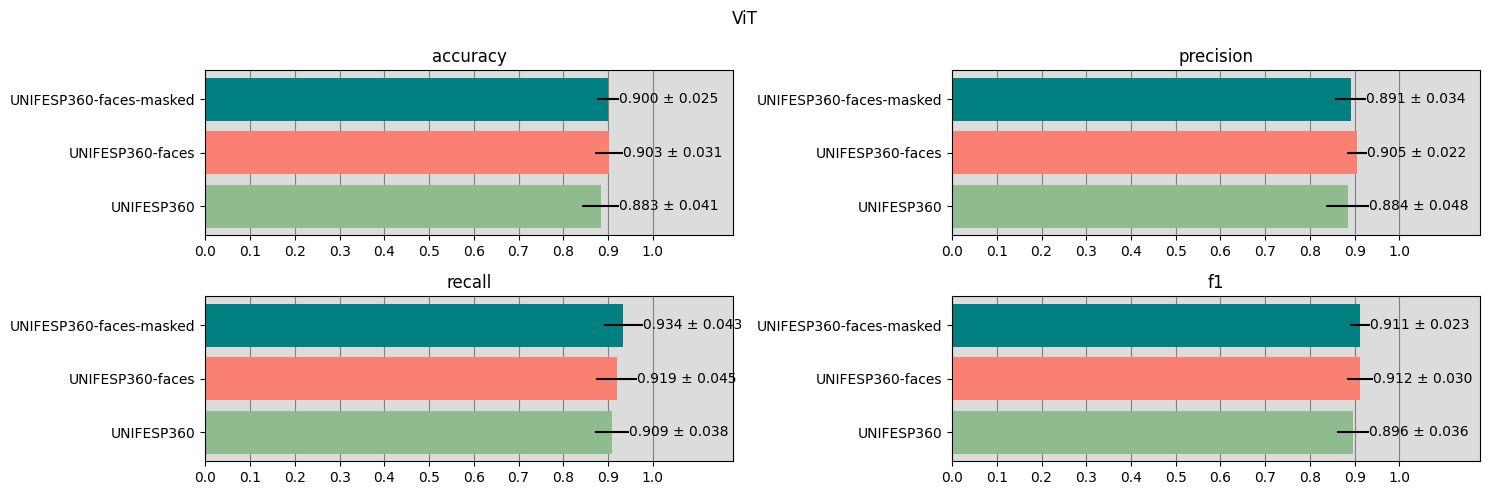

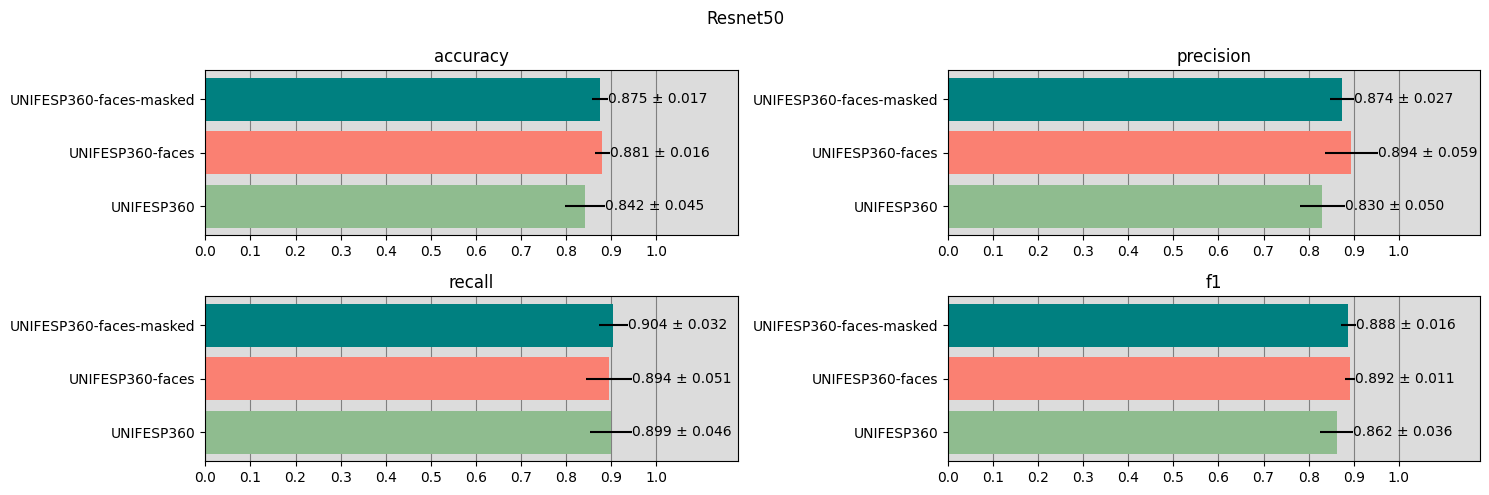

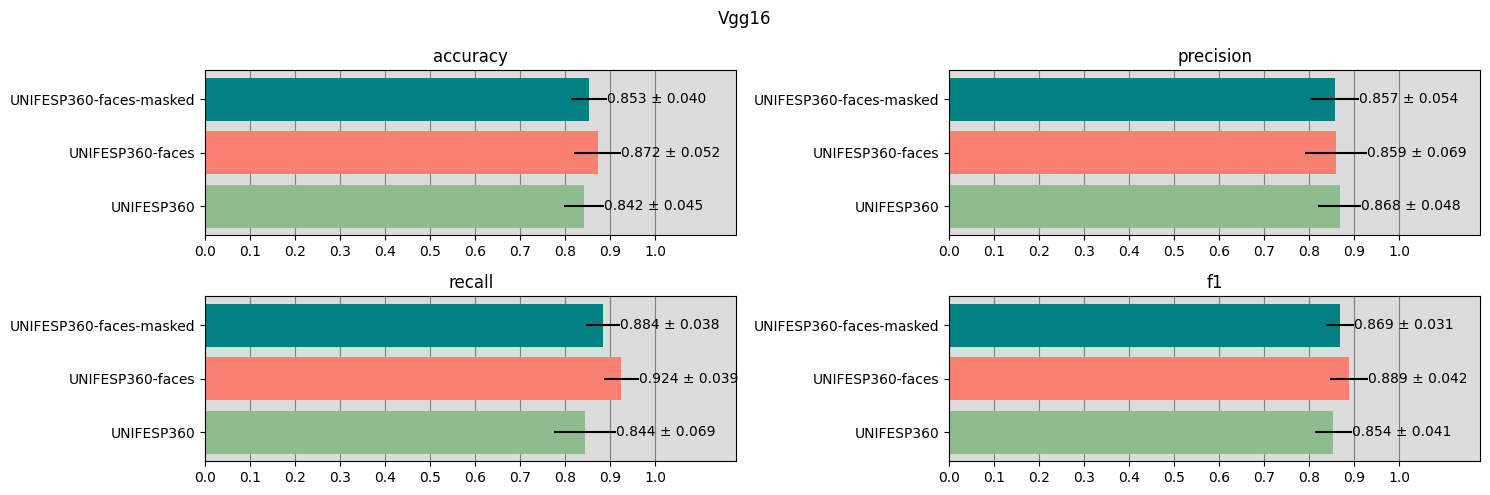

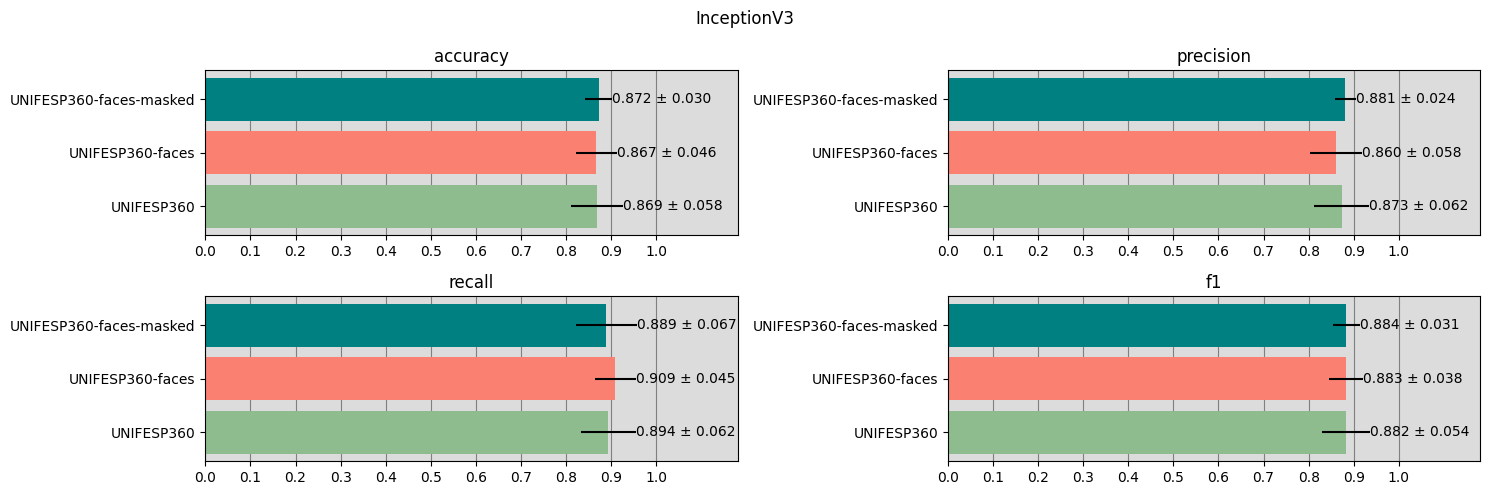

In [81]:
metrics = ['accuracy', 'precision', 'recall', 'f1']
p_values_table_index = list(combinations(datasets, 2))
p_values_table = {d: dict() for d in dirs_plot_names.values()}
p_values_table_wilcoxon = {d: dict() for d in dirs_plot_names.values()}
dfs = {}
for model in dirs_plot_names.values():
    fig, axs = plt.subplots(2,2,figsize=(15,5))
    fig.suptitle(model)

    dfs[model] = {ds: list() for ds in datasets}

    for count, metric in enumerate(metrics):
        j = count%2
        i = count//2
        means = []
        std_devs = []
        for ds in datasets:
            ds_mean = results[ds][model]['mean'][metric]
            ds_std_dev = results[ds][model]['std'][metric]
            means.append(ds_mean)
            std_devs.append(ds_std_dev)
            dfs[model][ds].append(f'{ds_mean:.3f}±{ds_std_dev:.3f}')

        if metric == TEST_METRIC:
            for ds1, ds2 in p_values_table_index:
                # T-Test
                t, p = ttest_ind_from_stats(
                    results[ds1][model]['mean'][TEST_METRIC], results[ds1][model]['std'][TEST_METRIC], 5, # Model 1 (mean, std_dev, number of samples)
                    results[ds2][model]['mean'][TEST_METRIC], results[ds2][model]['std'][TEST_METRIC], 5, # Model 2 (mean, std_dev, number of samples)
                    alternative='two-sided')
                p_values_table[model][(ds1,ds2)] = f"{'same' if p > p_threshold else 'different'} (p={p:.3f})"

                # Wilcoxon signed-rank
                result = wilcoxon(
                    results[ds1][model]['raw'][TEST_METRIC],
                    results[ds2][model]['raw'][TEST_METRIC],
                    alternative='two-sided')
                p_values_table_wilcoxon[model][(ds1,ds2)] = f"{'same' if result.pvalue > p_threshold else 'different'} (p={result.pvalue:.3f})"

        bars = datasets
        y_values = means
        errors = std_devs


        y_pos = np.arange(len(bars))
        hbars = axs[i][j].barh(
            y_pos,
            y_values,
            xerr=errors,
            color=['darkseagreen', 'salmon', 'teal', 'indigo'],
        )

        axs[i][j].set_title(metric)
        axs[i][j].set_axisbelow(True)
        axs[i][j].grid(axis='x', color='gray', zorder=0)
        axs[i][j].set_xlim(0,1.18)
        axs[i][j].bar_label(hbars, labels=[f'{mean:.3f} ± {std:.3f}' for mean,std in zip(means, std_devs)])
        axs[i][j].set_xticks([i/10 for i in range(11)])
        axs[i][j].set_yticks(y_pos, datasets)
        axs[i][j].set_facecolor('gainsboro')
    fig.tight_layout()

    dfs[model] = pd.DataFrame(dfs[model], index=metrics)
plt.show()

In [82]:
def bold(col):
    r = re.compile(r'0.[0-9]{3}')
    max_val = ('', -1)
    for metric, value_string in col.items():
        value = float(r.match(value_string).group(0))
        if value > max_val[1]:
            max_val = (metric, value)
    return ['font-weight: bold;' if max_val[0] == idx else '' for idx in col.index]

for ds in dfs:
    print(f'>>> MODEL: {ds}')
    display(dfs[ds].T.style.apply(bold))
    print('-'*50)
    

>>> MODEL: ViT


,accuracy,precision,recall,f1
UNIFESP360,0.883±0.041,0.884±0.048,0.909±0.038,0.896±0.036
UNIFESP360-faces,0.903±0.031,0.905±0.022,0.919±0.045,0.912±0.030
UNIFESP360-faces-masked,0.900±0.025,0.891±0.034,0.934±0.043,0.911±0.023


--------------------------------------------------
>>> MODEL: Resnet50


,accuracy,precision,recall,f1
UNIFESP360,0.842±0.045,0.830±0.050,0.899±0.046,0.862±0.036
UNIFESP360-faces,0.881±0.016,0.894±0.059,0.894±0.051,0.892±0.011
UNIFESP360-faces-masked,0.875±0.017,0.874±0.027,0.904±0.032,0.888±0.016


--------------------------------------------------
>>> MODEL: Vgg16


,accuracy,precision,recall,f1
UNIFESP360,0.842±0.045,0.868±0.048,0.844±0.069,0.854±0.041
UNIFESP360-faces,0.872±0.052,0.859±0.069,0.924±0.039,0.889±0.042
UNIFESP360-faces-masked,0.853±0.040,0.857±0.054,0.884±0.038,0.869±0.031


--------------------------------------------------
>>> MODEL: InceptionV3


,accuracy,precision,recall,f1
UNIFESP360,0.869±0.058,0.873±0.062,0.894±0.062,0.882±0.054
UNIFESP360-faces,0.867±0.046,0.860±0.058,0.909±0.045,0.883±0.038
UNIFESP360-faces-masked,0.872±0.030,0.881±0.024,0.889±0.067,0.884±0.031


--------------------------------------------------


In [83]:
print('Spearman')
p_df = pd.DataFrame(p_values_table, index=pd.MultiIndex.from_tuples(p_values_table_index))
display(p_df)
print('Wilcoxon signed-rank')
p_df_s = pd.DataFrame(p_values_table_wilcoxon, index=pd.MultiIndex.from_tuples(p_values_table_index))
display(p_df_s)

Spearman


ViT        Resnet50  \
UNIFESP360       UNIFESP360-faces         same (p=0.470)  same (p=0.118)   
                 UNIFESP360-faces-masked  same (p=0.446)  same (p=0.180)   
UNIFESP360-faces UNIFESP360-faces-masked  same (p=0.972)  same (p=0.686)   

                                                   Vgg16     InceptionV3  
UNIFESP360       UNIFESP360-faces         same (p=0.219)  same (p=0.989)  
                 UNIFESP360-faces-masked  same (p=0.533)  same (p=0.965)  
UNIFESP360-faces UNIFESP360-faces-masked  same (p=0.416)  same (p=0.971)

Wilcoxon signed-rank


ViT        Resnet50  \
UNIFESP360       UNIFESP360-faces         same (p=0.438)  same (p=0.068)   
                 UNIFESP360-faces-masked  same (p=0.465)  same (p=0.068)   
UNIFESP360-faces UNIFESP360-faces-masked  same (p=0.715)  same (p=0.465)   

                                                   Vgg16     InceptionV3  
UNIFESP360       UNIFESP360-faces         same (p=0.438)  same (p=0.625)  
                 UNIFESP360-faces-masked  same (p=0.625)  same (p=1.000)  
UNIFESP360-faces UNIFESP360-faces-masked  same (p=0.312)  same (p=1.000)

## Avaliando por região (mosaico)

In [65]:
results = {}
for ds in datasets_mosaico:
    results[ds] = {}
    for dir in eval_dirs:
        results[ds][dirs_plot_names[dir]] = {}
        for item_path in (RESULTS_PATH / dir / ds).rglob('*.csv'):
            region = item_path.parent.name[-2:]
            df = pd.read_csv(item_path)
            del df['K']
            del df['test_loss']
            del df['test_runtime']
            del df['test_samples_per_second']
            del df['test_steps_per_second']
            df = df.rename(columns={col: col.replace('test_', '') for col in df.columns})
            results[ds][dirs_plot_names[dir]][region] = {
                'raw': df,
                'mean': df.mean(axis=0,numeric_only=True),
                'std': df.std(axis=0,numeric_only=True),
            }

In [66]:
models = ['Vgg16', 'Resnet50', 'InceptionV3', 'ViT']
metrics = ['accuracy', 'precision', 'recall', 'f1']
regions = ['BA', 'BE', 'FP', 'FS', 'SN']
data = {dataset: {reg: {metric: list() for metric in metrics} for reg in regions} for dataset in datasets_mosaico}

for dataset in datasets_mosaico:
    for region in regions:
        for metric in metrics:
            for model in models:
                data[dataset][region][metric].append(f"{results[dataset][model][region]['mean'][metric]:.3f}±{results[dataset][model][region]['std'][metric]:.3f}")


for dataset in data:
    print(f">>> {dataset}")
    for region in data[dataset]:
        display(f"< {region} >")
        display(pd.DataFrame(data[dataset][region], index=models).style.apply(bold))
    display("-"*50)
        

>>> UNIFESP360_Face


'< BA >'

,accuracy,precision,recall,f1
Vgg16,0.847±0.125,0.824±0.146,0.826±0.149,0.824±0.143
Resnet50,0.867±0.092,0.842±0.105,0.853±0.142,0.845±0.113
InceptionV3,0.894±0.065,0.905±0.074,0.846±0.115,0.872±0.083
ViT,0.894±0.056,0.886±0.057,0.871±0.114,0.875±0.074


'< BE >'

,accuracy,precision,recall,f1
Vgg16,0.850±0.069,0.838±0.111,0.773±0.107,0.801±0.093
Resnet50,0.864±0.070,0.894±0.080,0.738±0.126,0.807±0.106
InceptionV3,0.861±0.055,0.839±0.066,0.801±0.114,0.817±0.077
ViT,0.906±0.040,0.905±0.069,0.851±0.047,0.876±0.051


'< FP >'

,accuracy,precision,recall,f1
Vgg16,0.822±0.134,0.795±0.154,0.845±0.074,0.816±0.119
Resnet50,0.828±0.061,0.840±0.054,0.770±0.170,0.792±0.098
InceptionV3,0.856±0.029,0.840±0.032,0.839±0.065,0.838±0.034
ViT,0.919±0.037,0.920±0.055,0.901±0.039,0.910±0.040


'< FS >'

,accuracy,precision,recall,f1
Vgg16,0.778±0.132,0.771±0.122,0.680±0.316,0.696±0.281
Resnet50,0.778±0.126,0.749±0.085,0.722±0.357,0.695±0.301
InceptionV3,0.836±0.112,0.839±0.110,0.795±0.205,0.808±0.154
ViT,0.858±0.085,0.899±0.097,0.777±0.115,0.833±0.107


'< SN >'

,accuracy,precision,recall,f1
Vgg16,0.775±0.109,0.758±0.152,0.719±0.093,0.735±0.116
Resnet50,0.814±0.063,0.844±0.087,0.691±0.149,0.753±0.113
InceptionV3,0.811±0.101,0.822±0.122,0.700±0.190,0.750±0.157
ViT,0.839±0.055,0.836±0.089,0.778±0.079,0.804±0.069


'--------------------------------------------------'

>>> UNIFESP360_Regiões


'< BA >'

,accuracy,precision,recall,f1
Vgg16,0.856±0.110,0.854±0.125,0.801±0.153,0.825±0.134
Resnet50,0.900±0.078,0.897±0.071,0.865±0.145,0.878±0.106
InceptionV3,0.881±0.066,0.885±0.071,0.834±0.114,0.856±0.080
ViT,0.906±0.062,0.925±0.022,0.854±0.155,0.881±0.087


'< BE >'

,accuracy,precision,recall,f1
Vgg16,0.853±0.073,0.813±0.104,0.816±0.081,0.814±0.090
Resnet50,0.881±0.071,0.894±0.078,0.788±0.127,0.836±0.101
InceptionV3,0.864±0.076,0.836±0.081,0.810±0.134,0.821±0.104
ViT,0.819±0.034,0.790±0.032,0.739±0.109,0.759±0.059


'< FP >'

,accuracy,precision,recall,f1
Vgg16,0.819±0.134,0.801±0.163,0.832±0.079,0.812±0.119
Resnet50,0.864±0.043,0.901±0.092,0.801±0.136,0.837±0.061
InceptionV3,0.867±0.047,0.908±0.065,0.789±0.124,0.837±0.071
ViT,0.811±0.058,0.852±0.050,0.701±0.147,0.761±0.099


'< FS >'

,accuracy,precision,recall,f1
Vgg16,0.775±0.142,0.779±0.147,0.668±0.312,0.693±0.284
Resnet50,0.797±0.147,0.674±0.381,0.692±0.388,0.682±0.383
InceptionV3,0.833±0.112,0.858±0.102,0.753±0.211,0.794±0.168
ViT,0.731±0.106,0.619±0.348,0.589±0.330,0.603±0.337


'< SN >'

,accuracy,precision,recall,f1
Vgg16,0.786±0.131,0.764±0.174,0.745±0.117,0.752±0.141
Resnet50,0.808±0.023,0.810±0.054,0.725±0.059,0.762±0.029
InceptionV3,0.842±0.032,0.847±0.052,0.771±0.063,0.805±0.040
ViT,0.814±0.072,0.840±0.095,0.698±0.131,0.758±0.096


'--------------------------------------------------'

In [67]:
models = ['Vgg16', 'Resnet50', 'InceptionV3', 'ViT']
regions = ['BA', 'BE', 'FP', 'FS', 'SN']
metric = TEST_METRIC
data = {dataset: {reg: list() for reg in regions} for dataset in datasets_mosaico}

for dataset in datasets_mosaico:
    for region in regions:
        for model in models:
            data[dataset][region].append(f"{results[dataset][model][region]['mean'][metric]:.3f}±{results[dataset][model][region]['std'][metric]:.3f}")


for dataset in data:
    print(f">>> {dataset}")
    display(pd.DataFrame(data[dataset], index=models).style.apply(bold))
        

>>> UNIFESP360_Face


,BA,BE,FP,FS,SN
Vgg16,0.824±0.143,0.801±0.093,0.816±0.119,0.696±0.281,0.735±0.116
Resnet50,0.845±0.113,0.807±0.106,0.792±0.098,0.695±0.301,0.753±0.113
InceptionV3,0.872±0.083,0.817±0.077,0.838±0.034,0.808±0.154,0.750±0.157
ViT,0.875±0.074,0.876±0.051,0.910±0.040,0.833±0.107,0.804±0.069


>>> UNIFESP360_Regiões


,BA,BE,FP,FS,SN
Vgg16,0.825±0.134,0.814±0.090,0.812±0.119,0.693±0.284,0.752±0.141
Resnet50,0.878±0.106,0.836±0.101,0.837±0.061,0.682±0.383,0.762±0.029
InceptionV3,0.856±0.080,0.821±0.104,0.837±0.071,0.794±0.168,0.805±0.040
ViT,0.881±0.087,0.759±0.059,0.761±0.099,0.603±0.337,0.758±0.096


In [68]:
models = ['Vgg16', 'Resnet50', 'InceptionV3', 'ViT']
metrics = ['accuracy', 'precision', 'recall', 'f1']
regions = ['BA', 'BE', 'FP', 'FS', 'SN']
data = {model: {reg: {metric: list() for metric in metrics} for reg in regions} for model in models}

for model in models:
    for region in regions:
        for metric in metrics:
            for dataset in datasets_mosaico:
                data[model][region][metric].append(f"{results[dataset][model][region]['mean'][metric]:.3f}±{results[dataset][model][region]['std'][metric]:.3f}")

for model in data:
    print(f">>> {model}")
    for region in data[model]:
        display(f"< {region} >")
        display(pd.DataFrame(data[model][region], index=datasets_mosaico).style.apply(bold))
    display("-"*50)
        

>>> Vgg16


'< BA >'

,accuracy,precision,recall,f1
UNIFESP360_Face,0.847±0.125,0.824±0.146,0.826±0.149,0.824±0.143
UNIFESP360_Regiões,0.856±0.110,0.854±0.125,0.801±0.153,0.825±0.134


'< BE >'

,accuracy,precision,recall,f1
UNIFESP360_Face,0.850±0.069,0.838±0.111,0.773±0.107,0.801±0.093
UNIFESP360_Regiões,0.853±0.073,0.813±0.104,0.816±0.081,0.814±0.090


'< FP >'

,accuracy,precision,recall,f1
UNIFESP360_Face,0.822±0.134,0.795±0.154,0.845±0.074,0.816±0.119
UNIFESP360_Regiões,0.819±0.134,0.801±0.163,0.832±0.079,0.812±0.119


'< FS >'

,accuracy,precision,recall,f1
UNIFESP360_Face,0.778±0.132,0.771±0.122,0.680±0.316,0.696±0.281
UNIFESP360_Regiões,0.775±0.142,0.779±0.147,0.668±0.312,0.693±0.284


'< SN >'

,accuracy,precision,recall,f1
UNIFESP360_Face,0.775±0.109,0.758±0.152,0.719±0.093,0.735±0.116
UNIFESP360_Regiões,0.786±0.131,0.764±0.174,0.745±0.117,0.752±0.141


'--------------------------------------------------'

>>> Resnet50


'< BA >'

,accuracy,precision,recall,f1
UNIFESP360_Face,0.867±0.092,0.842±0.105,0.853±0.142,0.845±0.113
UNIFESP360_Regiões,0.900±0.078,0.897±0.071,0.865±0.145,0.878±0.106


'< BE >'

,accuracy,precision,recall,f1
UNIFESP360_Face,0.864±0.070,0.894±0.080,0.738±0.126,0.807±0.106
UNIFESP360_Regiões,0.881±0.071,0.894±0.078,0.788±0.127,0.836±0.101


'< FP >'

,accuracy,precision,recall,f1
UNIFESP360_Face,0.828±0.061,0.840±0.054,0.770±0.170,0.792±0.098
UNIFESP360_Regiões,0.864±0.043,0.901±0.092,0.801±0.136,0.837±0.061


'< FS >'

,accuracy,precision,recall,f1
UNIFESP360_Face,0.778±0.126,0.749±0.085,0.722±0.357,0.695±0.301
UNIFESP360_Regiões,0.797±0.147,0.674±0.381,0.692±0.388,0.682±0.383


'< SN >'

,accuracy,precision,recall,f1
UNIFESP360_Face,0.814±0.063,0.844±0.087,0.691±0.149,0.753±0.113
UNIFESP360_Regiões,0.808±0.023,0.810±0.054,0.725±0.059,0.762±0.029


'--------------------------------------------------'

>>> InceptionV3


'< BA >'

,accuracy,precision,recall,f1
UNIFESP360_Face,0.894±0.065,0.905±0.074,0.846±0.115,0.872±0.083
UNIFESP360_Regiões,0.881±0.066,0.885±0.071,0.834±0.114,0.856±0.080


'< BE >'

,accuracy,precision,recall,f1
UNIFESP360_Face,0.861±0.055,0.839±0.066,0.801±0.114,0.817±0.077
UNIFESP360_Regiões,0.864±0.076,0.836±0.081,0.810±0.134,0.821±0.104


'< FP >'

,accuracy,precision,recall,f1
UNIFESP360_Face,0.856±0.029,0.840±0.032,0.839±0.065,0.838±0.034
UNIFESP360_Regiões,0.867±0.047,0.908±0.065,0.789±0.124,0.837±0.071


'< FS >'

,accuracy,precision,recall,f1
UNIFESP360_Face,0.836±0.112,0.839±0.110,0.795±0.205,0.808±0.154
UNIFESP360_Regiões,0.833±0.112,0.858±0.102,0.753±0.211,0.794±0.168


'< SN >'

,accuracy,precision,recall,f1
UNIFESP360_Face,0.811±0.101,0.822±0.122,0.700±0.190,0.750±0.157
UNIFESP360_Regiões,0.842±0.032,0.847±0.052,0.771±0.063,0.805±0.040


'--------------------------------------------------'

>>> ViT


'< BA >'

,accuracy,precision,recall,f1
UNIFESP360_Face,0.894±0.056,0.886±0.057,0.871±0.114,0.875±0.074
UNIFESP360_Regiões,0.906±0.062,0.925±0.022,0.854±0.155,0.881±0.087


'< BE >'

,accuracy,precision,recall,f1
UNIFESP360_Face,0.906±0.040,0.905±0.069,0.851±0.047,0.876±0.051
UNIFESP360_Regiões,0.819±0.034,0.790±0.032,0.739±0.109,0.759±0.059


'< FP >'

,accuracy,precision,recall,f1
UNIFESP360_Face,0.919±0.037,0.920±0.055,0.901±0.039,0.910±0.040
UNIFESP360_Regiões,0.811±0.058,0.852±0.050,0.701±0.147,0.761±0.099


'< FS >'

,accuracy,precision,recall,f1
UNIFESP360_Face,0.858±0.085,0.899±0.097,0.777±0.115,0.833±0.107
UNIFESP360_Regiões,0.731±0.106,0.619±0.348,0.589±0.330,0.603±0.337


'< SN >'

,accuracy,precision,recall,f1
UNIFESP360_Face,0.839±0.055,0.836±0.089,0.778±0.079,0.804±0.069
UNIFESP360_Regiões,0.814±0.072,0.840±0.095,0.698±0.131,0.758±0.096


'--------------------------------------------------'

In [69]:
models = ['Vgg16', 'Resnet50', 'InceptionV3', 'ViT']
regions = ['BA', 'BE', 'FP', 'FS', 'SN']
metric = TEST_METRIC
data = {model: {reg: {metric: list() for metric in metrics} for reg in regions} for model in models}
data = {model: {reg: list() for reg in regions} for model in models}

for model in models:
    for region in regions:
        for dataset in datasets_mosaico:
            data[model][region].append(f"{results[dataset][model][region]['mean'][metric]:.3f}±{results[dataset][model][region]['std'][metric]:.3f}")

for model in data:
    print(f">>> {model}")
    display(pd.DataFrame(data[model], index=datasets_mosaico).style.apply(bold))

>>> Vgg16


,BA,BE,FP,FS,SN
UNIFESP360_Face,0.824±0.143,0.801±0.093,0.816±0.119,0.696±0.281,0.735±0.116
UNIFESP360_Regiões,0.825±0.134,0.814±0.090,0.812±0.119,0.693±0.284,0.752±0.141


>>> Resnet50


,BA,BE,FP,FS,SN
UNIFESP360_Face,0.845±0.113,0.807±0.106,0.792±0.098,0.695±0.301,0.753±0.113
UNIFESP360_Regiões,0.878±0.106,0.836±0.101,0.837±0.061,0.682±0.383,0.762±0.029


>>> InceptionV3


,BA,BE,FP,FS,SN
UNIFESP360_Face,0.872±0.083,0.817±0.077,0.838±0.034,0.808±0.154,0.750±0.157
UNIFESP360_Regiões,0.856±0.080,0.821±0.104,0.837±0.071,0.794±0.168,0.805±0.040


>>> ViT


,BA,BE,FP,FS,SN
UNIFESP360_Face,0.875±0.074,0.876±0.051,0.910±0.040,0.833±0.107,0.804±0.069
UNIFESP360_Regiões,0.881±0.087,0.759±0.059,0.761±0.099,0.603±0.337,0.758±0.096


## UNIFESP360_Face = Input: Imagem completa
## UNIFESP360_Regiões = Input: Recorte do mosaico